## Cancer Survival Outcome Model
Trained models using sci-kit learn and XGBoost to predict cancer survival outcomes

This dataset was taken from the Molecular Taxonomy of Breast Cancer Internatial Consortium (METRABRIC) database, which is a Canada-UK project of ~2000 breast cancer samples (https://www.cbioportal.org/study/summary?id=brca_metabric)
- Author: Spencer Friedman
- Project: https://github.com/ssfriedman1/Breast-Cancer_Data


### Importing Libraries  ###

In [1]:
from __future__ import absolute_import,division,print_function, unicode_literals


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Importing Sklearn packages
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest, skew
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Modeling libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn import metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe



from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from cmath import nan

### Importing CSV file ###

In [2]:
dftrain = pd.read_csv('METABRIC_RNA_Mutation.csv')
dftrain.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


Initial view of the shape and components of the dataframe

In [3]:
dftrain.dtypes

patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object

In [4]:
print(f"The shape of the train data set is: {dftrain.shape}")
dftrain.info()

The shape of the train data set is: (1904, 693)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


### Preliminary analysis ###

The dataframe is made up mostly of numerical values (503/693), with the remaining 190 being object values that will need to be engineered to be interpretted by the algorithm

In [5]:
#Finding missing data and the percentage of it in each column
total = dftrain.isnull().sum().sort_values(ascending = False) # Finding total number of missing values per column
percent = (dftrain.isnull().sum() / dftrain.isnull().count()).sort_values(ascending=False) # calculating percent of missing values
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan']) # concatting data to one table to view
missing_data.head(20)

,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
neoplasm_histologic_grade,72,0.037815
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
cancer_type_detailed,15,0.007878


From the above, the values that are missing are only clinical values, meaning they have no genetic information, and therefore it would make most sense to isolate those clinical values to better be able to represent and work with them. I will do that below.

In [6]:
dftrain.columns[:31] # tested values to find all columns representing the clinical values

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

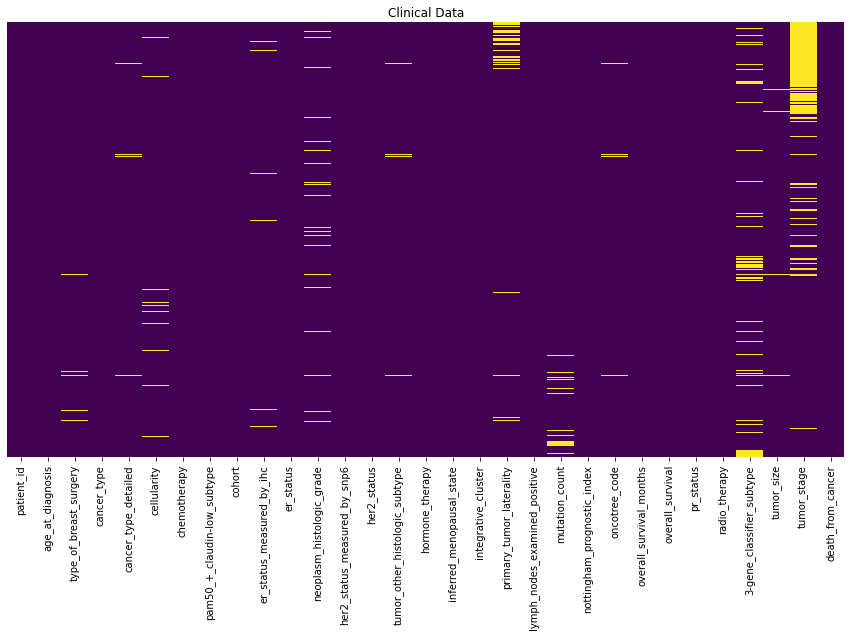

In [7]:
non_clinical_data = dftrain.columns[31:] # All non clinical features
clinical_data = dftrain.drop(non_clinical_data, axis = 1) # dropping all clinical features
categorical_vals = clinical_data.select_dtypes(include=['object']).columns.tolist()
clinical_df = pd.get_dummies(clinical_data, columns = categorical_vals)
# Graphing the null values of the clinical features 
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(clinical_data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
ax.set_title('Clinical Data')
ax.invert_yaxis()
plt.show;

This gives us a sense of the trends in the missing data, and whether or not certain pockets of patients were missing the same entries. In this case, there are a few minor trends, but generally nothing of any concern

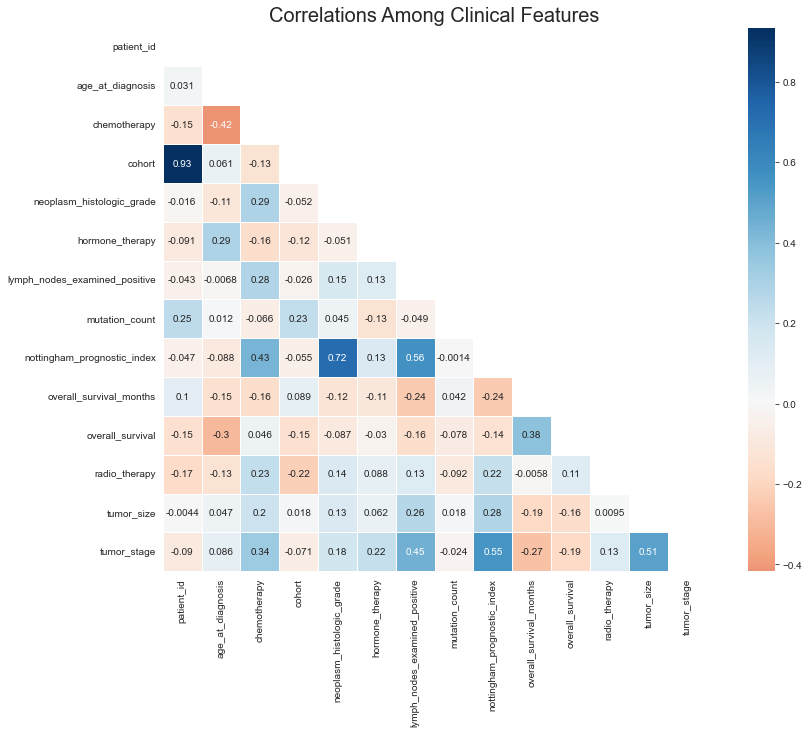

In [8]:
corr  = clinical_data.corr() # calculate correlations between clinical values
mask = np.zeros_like(corr, dtype= bool) # create additional zeros matrix and fill in with correlation values
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,10))
sns.heatmap(corr, annot = True, mask= mask, cmap = 'RdBu', linewidth = 0.9, linecolor  ='white', center = 0, square = True) # graph correlations in a heatmap along with values of correlation
plt.title('Correlations Among Clinical Features', y = 1.00, fontsize = 20);

#### Positive Correlations #### 
- Tumor stage and nottingham prognostic index
- Neoplasm histologic grade and nottingham prognostic index
- Cohort and ID
- Nottingham and positive lymph nodes
- Tumor size and stage
#### Negative correlations ####
- Overall survival and age
- Chemotherapy and age
- Tumor stage and survival months


### Data Exploration and Visualization ###
Creating visuals of data to determine initial trends

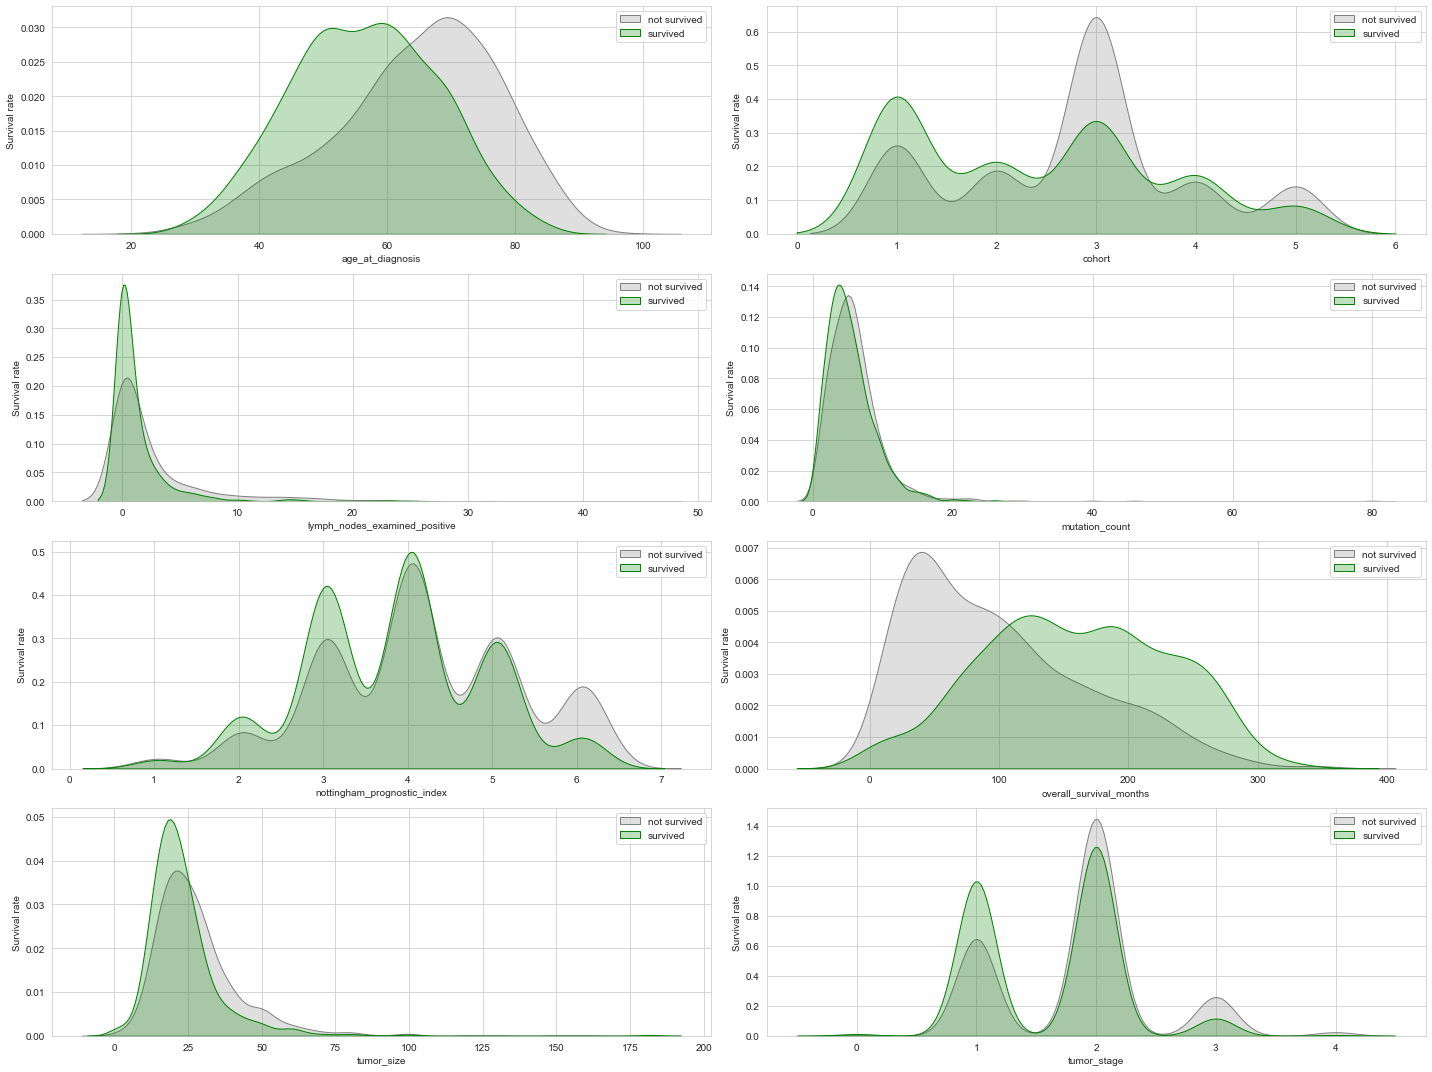

In [9]:
# Graphing numerical values to their correlation to survival rate to get some initial understandings of correlation
numerical_values = ['age_at_diagnosis', 'cohort', 'lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index','overall_survival_months','tumor_size','tumor_stage']
a = 4 # num of rows
b = 2 # num of colums
c =1 # initializer value
fig, ax = plt.subplots(figsize = (20,15))
for i in numerical_values:
    plt.subplot(a,b,c)
    sns.kdeplot(dftrain.loc[(clinical_data['overall_survival'] == 0), i ] , color='gray',shade=True,label='not survived')
    sns.kdeplot(dftrain.loc[(clinical_data['overall_survival'] == 1), i] , color='g',shade=True, label='survived')
    plt.ylabel('Survival rate')
    plt.legend()
    c = c+1

plt.tight_layout()
plt.show()

#### Initial Assumptions from clinical data ####
- Age of diagnosis > 70 results in lower survival rate
- Unsure of what the cohort mean but seem to correlate to lower survival in 3 and 5
- Lymph nodes positive over 5 are bad for survival
- Mutation count > ~5 bad for survival
- Nottingham index > 4 bad for survival
- Tumor size > 25 bad for survival
- Tumor stage >= 2 bad for survival

While the clinical data makes up a very small portion of the overall data available, it might start to give us a good insight into those who survive and don't and will help make easy indicators to train the model in the future. 

In [10]:
#Finding missing data and the percentage of it in each column
total = dftrain.isnull().sum().sort_values(ascending = False)
percent = (dftrain.isnull().sum() / dftrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(15)

,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
neoplasm_histologic_grade,72,0.037815
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
cancer_type_detailed,15,0.007878


In [11]:
clinical_data[clinical_data.death_from_cancer.isnull()] # finding singular death from cancer missing value

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
1166,5130,58.61,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Low,0,LumA,3.0,Positve,...,4.03,IDC,255.0,0,Positive,1,ER+/HER2- High Prolif,15.0,1.0,NaN


IMPORTANT FEATURES OF THIS PATIENT \
Age = 59 \
Survival months = 255 \
Overall survival = 0 \
Tumor size = 15 \
Cohort = 3 \
Tumor stage = 1 \
Although this person has certain features like age and survival months that point towards survival, since they did die and had cohort 3 and nottingham index of 4, it is very likely that they did die of cancer, so I will assume that as cause of dead for the purpose of the model. 


In [12]:
dftrain.death_from_cancer.fillna('Died of Disease', inplace= True)

Filling in certain columns with mean values of those columns

In [13]:
clinical_data['mutation_count'] = clinical_data['mutation_count'].fillna(clinical_data['mutation_count'].mean())
clinical_data['tumor_size'] = clinical_data['tumor_size'].fillna(clinical_data['tumor_size'].mean())
dftrain['mutation_count'] = dftrain['mutation_count'].fillna(dftrain['mutation_count'].mean())
dftrain['tumor_size'] = dftrain['tumor_size'].fillna(dftrain['tumor_size'].mean())

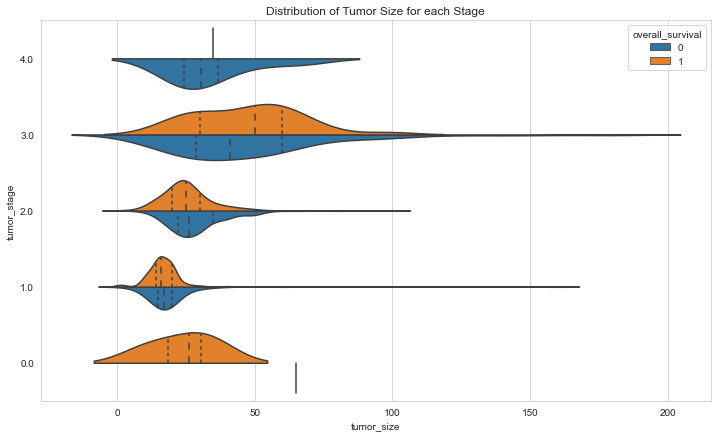

In [14]:
fig, ax = plt.subplots(figsize = (12,7))
sns.violinplot(x = 'tumor_size', y= 'tumor_stage', hue = 'overall_survival', data = clinical_data, orient = 'h', split=True, inner= 'quart')
plt.title("Distribution of Tumor Size for each Stage")
ax.invert_yaxis()

At tumor stage 3, there is the widest range of sizes associated. Generally as tumor stage increases, tumor size also increases except for stage 4, where tumor size is smaller but survival rate is also extremely low. Interestingly, the average tumor size for stage 3 is larger for those that survived than those that didn't.

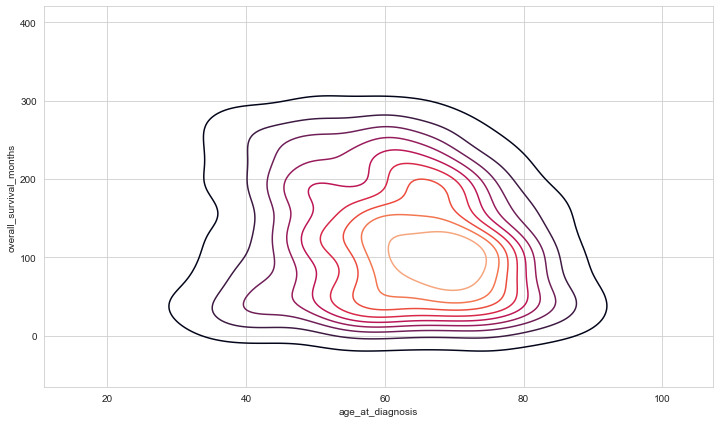

In [15]:
fig, ax = plt.subplots(figsize = (12,7))

sns.kdeplot(x= 'age_at_diagnosis', y = 'overall_survival_months', data = clinical_data, cmap = 'rocket', fill = False);


As age increases, the overall survival months decreases, which checks out with common knowledge that immune systems weaken with old age. 

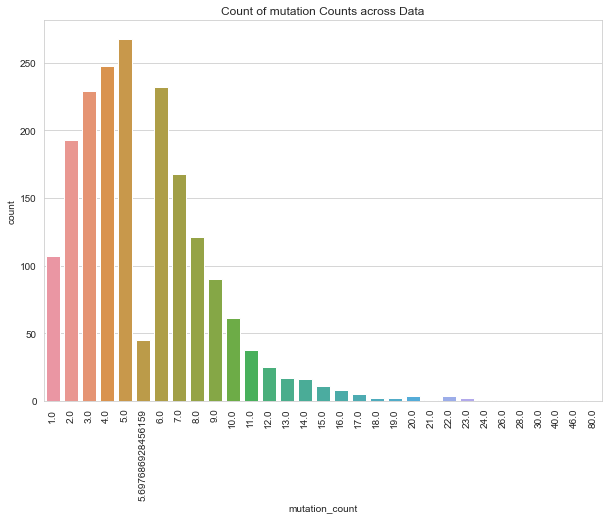

In [16]:
plt.subplots(figsize = (10,7))
sns.countplot(x = 'mutation_count', data = dftrain)
plt.title('Count of mutation Counts across Data')
plt.tick_params(labelrotation = 90, axis = 'x')

- Right skew in the data for mutation count
- The abnmormal dip and long number is the mean value that was filled in

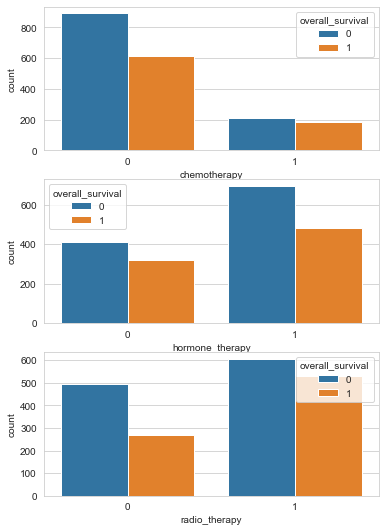

In [17]:
therapies = ['chemotherapy', 'hormone_therapy', 'radio_therapy']
a = 3
b =1
c =1
fig, ax = plt.subplots(figsize = (6,9))
for i in therapies:
    plt.subplot(a,b,c)
    sns.countplot(x = i, hue = 'overall_survival', data = clinical_data)
    c = c+1

Hormone therapy has a relatively low rate of success, whereas radio and chemotherapy both have almost equal success to failure values. Radio therapy seems to be most successful since those that did not recieve the treatment had the highest rate of death. 

### Calculating correlations between all features to overall survival
Using the handy .corr() function, we are able to calculate the correlation between all the columns in the data to the overall survival of the patients
This will be useful in feature selection in the future

In [18]:
corr_survival = clinical_df.corr()['overall_survival'].sort_values(ascending = False)
corr_dataframe = pd.DataFrame({"Correlation": corr_survival})
corr_dataframe.head(20)

,Correlation
death_from_cancer_Living,1.000000
overall_survival,1.000000
overall_survival_months,0.384467
type_of_breast_surgery_BREAST CONSERVING,0.187856
inferred_menopausal_state_Pre,0.170915
radio_therapy,0.112083
3-gene_classifier_subtype_ER+/HER2- Low Prolif,0.094463
pam50_+_claudin-low_subtype_claudin-low,0.091397
integrative_cluster_10,0.076256
pam50_+_claudin-low_subtype_LumA,0.065186


In [19]:
corr_dataframe.tail(10)

,Correlation
patient_id,-0.148052
cohort,-0.149645
tumor_size,-0.164361
lymph_nodes_examined_positive,-0.164498
inferred_menopausal_state_Post,-0.170915
type_of_breast_surgery_MASTECTOMY,-0.184259
tumor_stage,-0.188790
age_at_diagnosis,-0.303666
death_from_cancer_Died of Other Causes,-0.494759
death_from_cancer_Died of Disease,-0.593581


## Correlations ##

### Positive correlation ###
between survival and survival months, breast conserving surgery, pre menopausal state, and radio therapy usage to name a few. 

### Negative correlation ###
between survival and age of diagnosis, tumor stage, mastectomy surgery and post menopausal state and positive lymph nodes. 

# Statistical Exploration


In [20]:
clinical_data.dtypes

patient_id                          int64
age_at_diagnosis                  float64
type_of_breast_surgery             object
cancer_type                        object
cancer_type_detailed               object
cellularity                        object
chemotherapy                        int64
pam50_+_claudin-low_subtype        object
cohort                            float64
er_status_measured_by_ihc          object
er_status                          object
neoplasm_histologic_grade         float64
her2_status_measured_by_snp6       object
her2_status                        object
tumor_other_histologic_subtype     object
hormone_therapy                     int64
inferred_menopausal_state          object
integrative_cluster                object
primary_tumor_laterality           object
lymph_nodes_examined_positive     float64
mutation_count                    float64
nottingham_prognostic_index       float64
oncotree_code                      object
overall_survival_months           

In [21]:
numerical_values_clinical = ['age_at_diagnosis','lymph_nodes_examined_positive','mutation_count','overall_survival_months','tumor_size','nottingham_prognostic_index'] # Data values that represent scale of values
bucket_values_clinical = ['neoplasm_histologic_grade','tumor_stage','cohort','chemotherapy'] # Numerical values that represent bucketed data values
clinical_df[numerical_values_clinical].describe()

,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,overall_survival_months,tumor_size,nottingham_prognostic_index
count,1904.000000,1904.000000,1859.000000,1904.000000,1884.000000,1904.000000
mean,61.087054,2.002101,5.697687,125.121324,26.238726,4.033019
std,12.978711,4.079993,4.058778,76.334148,15.160976,1.144492
min,21.930000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,51.375000,0.000000,3.000000,60.825000,17.000000,3.046000
50%,61.770000,0.000000,5.000000,115.616667,23.000000,4.042000
75%,70.592500,2.000000,7.000000,184.716667,30.000000,5.040250
max,96.290000,45.000000,80.000000,355.200000,182.000000,6.360000


In [22]:
clinical_df[bucket_values_clinical].describe()

,neoplasm_histologic_grade,tumor_stage,cohort,chemotherapy
count,1832.000000,1403.000000,1904.000000,1904.000000
mean,2.415939,1.750535,2.643908,0.207983
std,0.650612,0.628999,1.228615,0.405971
min,1.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000
50%,3.000000,2.000000,3.000000,0.000000
75%,3.000000,2.000000,3.000000,0.000000
max,3.000000,4.000000,5.000000,1.000000


In [23]:
clinical_data.astype("category").describe().T

,count,unique,top,freq
patient_id,1904,1904,0,1
age_at_diagnosis,1904.0,1572.0,49.61,5.0
type_of_breast_surgery,1882,2,MASTECTOMY,1127
cancer_type,1904,2,Breast Cancer,1903
cancer_type_detailed,1889,6,Breast Invasive Ductal Carcinoma,1500
cellularity,1850,3,High,939
chemotherapy,1904,2,0,1508
pam50_+_claudin-low_subtype,1904,7,LumA,679
cohort,1904.0,5.0,3.0,734.0
er_status_measured_by_ihc,1874,2,Positve,1445


This gives us an idea of the most frequent values of each of the clinical features, which may indicate which features are most important for the model building

In [24]:
corr_survival = dftrain.corr()['overall_survival'].sort_values(ascending = False)
corr_dataframe = pd.DataFrame({"Correlation": corr_survival})
corr_dataframe

,Correlation
overall_survival,1.000000
overall_survival_months,0.384467
hsd17b11,0.216095
cdkn2c,0.197379
jak1,0.194412
...,...
map4,-0.165276
kmt2c,-0.171925
gsk3b,-0.186323
tumor_stage,-0.188790


This gives us our first exposure to the genetic data, which we have left alone until now because there is not much we can actually do without researching what each of the genes and mutations are. It is already clear that some genes contribute positively or negatively to the survival rate of the patient and will most likely be important for training our model. 

## Feature Engineering
Using various functions I make to change categorical features that represented groups to numbers, so that they can be interpretted by the ML models later on

In [25]:
clinical_data.select_dtypes(include=[np.object])

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype,death_from_cancer
0,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,claudin-low,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,4ER+,Right,IDC,Negative,ER-/HER2-,Living
1,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,4ER+,Right,IDC,Positive,ER+/HER2- High Prolif,Living
2,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Pre,3,Right,IDC,Positive,NaN,Died of Disease
3,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Pre,9,Right,MDLC,Positive,NaN,Living
4,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Mixed,Post,9,Right,MDLC,Positive,ER+/HER2- High Prolif,Died of Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Lobular,Pre,3,Right,ILC,Positive,ER+/HER2- Low Prolif,Living
1900,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,GAIN,Positive,Ductal/NST,Pre,5,NaN,IDC,Negative,NaN,Died of Disease
1901,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,1,Left,IDC,Positive,NaN,Died of Disease
1902,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,LumB,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,1,NaN,IDC,Positive,ER+/HER2- High Prolif,Died of Other Causes


In [26]:
clinical_data.cancer_type.value_counts()

Breast Cancer     1903
Breast Sarcoma       1
Name: cancer_type, dtype: int64

In [27]:
clinical_data[clinical_data.cancer_type == 'Breast Sarcoma']

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
170,284,51.42,NaN,Breast Sarcoma,Breast Invasive Ductal Carcinoma,Moderate,0,claudin-low,1.0,NaN,...,1.0,IDC,0.0,1,Negative,0,ER-/HER2-,26.238726,NaN,Living


This patient has a lot of missing values and won't really contribute to much to our data, and since all the others have the same value for type of cancer, we can go ahead and drop the whole column.


In [28]:
dftrain = dftrain.drop('cancer_type', axis = 1)
# Dropping redundant features
dftrain.drop('oncotree_code', axis =1, inplace=True)
dftrain.drop('tumor_other_histologic_subtype', axis = 1, inplace=True)  

In [29]:
def cellularity(value):
    c = 0
    if value == 'High':
        c = 3
    elif value == 'Moderate':
        c = 2
    elif value == 'Low':
        c = 1
    return c


dftrain['cellularity_group'] = dftrain['cellularity'].map(cellularity)

In [30]:
dftrain.neoplasm_histologic_grade.fillna("N", inplace = True)
# Comparing to nottingham index due to high correlation in values 
dftrain.groupby('neoplasm_histologic_grade', as_index=False)['nottingham_prognostic_index'].mean()


,neoplasm_histologic_grade,nottingham_prognostic_index
0,1.0,2.463097
1,2.0,3.610637
2,3.0,4.815522
3,N,1.897175


In [31]:
# Function to get rid of the missing neoplasm grade values by using averages of available values
def neoplasm_grade(value):
    grade = 0
    if value < 3:
        grade = 1
    elif value >= 3 and value < 4.2:
        grade = 2
    else:
        grade = 3
    return grade

with_N = dftrain[dftrain.neoplasm_histologic_grade == 'N']
without_N = dftrain[dftrain.neoplasm_histologic_grade != 'N']

with_N['neoplasm_histologic_grade'] = with_N.nottingham_prognostic_index.apply(lambda x: neoplasm_grade(x))
all_data = pd.concat([with_N, without_N], axis = 0)
all_data.sort_values(by = 'patient_id', inplace=True)
dftrain = all_data

In [32]:
dftrain['integrative_cluster'].unique()

array(['4ER+', '3', '9', '7', '4ER-', '5', '8', '10', '1', '2', '6'],
      dtype=object)

In [33]:
def cluster_group(int):
    value = 0
    if int == '1':
        value = 1
    elif int == '2':
        value = 2
    elif int == '3':
        value = 3
    elif int == '4ER-':
        value = 4
    elif int == '4ER+':
        value = 4.5
    elif int == '5':
        value = 5
    elif int == '6':
        value = 6
    elif int == '7':
        value = 7
    elif int == '8':
        value = 8
    elif int == '9':
        value = 9
    elif int == '10':
        value = 10
    return value
dftrain['cluster_group'] = dftrain['integrative_cluster'].map(cluster_group)
dftrain.drop('integrative_cluster', axis =1, inplace= True)

In [34]:
dftrain['cellularity'].unique()

array([nan, 'High', 'Moderate', 'Low'], dtype=object)

In [35]:
def cellularity_group(cell):
    value = 0 
    if cell == "High":
        value = 3
    elif cell == 'Moderate':
        value = 2
    elif cell == "Low":
        value = 1
    return value

dftrain['cellularity_group'] = dftrain['cellularity'].map(cellularity_group)
dftrain.drop('cellularity', axis=1, inplace = True)

In [36]:
dftrain['er_status_measured_by_ihc'].unique()

array(['Positve', 'Negative', nan], dtype=object)

In [37]:
def er_group(stat):
    value = 0
    if stat == 'Positve' or 'Positive':
        value = 1
    elif stat == 'Negative':
        value = 0
    return value

dftrain['er_group_ilc'] = dftrain['er_status_measured_by_ihc'].map(er_group)
dftrain['er_group'] = dftrain['er_status'].map(er_group)
dftrain.drop('er_status_measured_by_ihc', axis=1, inplace=True)
dftrain.drop('er_status', axis =1, inplace=True)

In [38]:
dftrain['her2_status_measured_by_snp6'].unique()
dftrain['her2_status'].unique()
dftrain['pr_status'].unique()

array(['Negative', 'Positive'], dtype=object)

In [39]:
def her2_group(stat):
    value = 0
    if stat == 'NEUTRAL' or 'Negative':
        value = 0
    elif stat == "LOSS":
        value = -1
    elif stat == "GAIN" or 'Positive':
        value = 1
    else:
        value = nan
    return value
dftrain['her2_group_snp6'] = dftrain['her2_status_measured_by_snp6'].map(her2_group)
dftrain['her2_group'] = dftrain['her2_status'].map(her2_group)
dftrain['pr_group'] = dftrain['pr_status'].map(her2_group)
dftrain.drop('her2_status_measured_by_snp6', axis=1, inplace=True)
dftrain.drop('her2_status', axis=1, inplace=True)
dftrain.drop('pr_status',axis=1, inplace=True)

In [40]:
dftrain.drop(['patient_id', 'death_from_cancer'], axis=1, inplace=True) # dropping columns not needed for the data or that interfere with the model

In [41]:
# Create dummy variables for all object datatypes so that they can be interpretted by models
dftrain = pd.get_dummies(dftrain, columns = dftrain.select_dtypes(include=['object']).columns, drop_first=True ) 

In [42]:
## WORK IN PROGRESS TO FIll IN Missing tumor stage data
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# def tumor_stage(df):
#     stage_df = df.drop('overall_survival', axis = 1)

#     temp_train = stage_df.loc[stage_df.tumor_stage.notnull()]
#     temp_test = stage_df.loc[stage_df.tumor_stage.isnull()]

#     y = temp_train.tumor_stage.values
#     x = temp_train.values

#     imp = IterativeImputer(max_iter=10, n_nearest_features = 20, random_state=0)
#     imp.fit(x,y)

#     predicted_stage = imp.predict(temp_train)
#     df.loc[df.tumor_stage.isnull(), 'tumor_stage'] = predicted_stage

# tumor_stage(dftrain)

In [43]:
dftrain.dropna(axis = 0, inplace=True)  # Drop all remaining missing values to start training the models

# Model Training #
### Preparing the data ###

In [44]:
X = dftrain.drop(['overall_survival'], axis =1)
y = dftrain['overall_survival']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

st_scale = StandardScaler()
X_train = st_scale.fit_transform(X_train) # use the standard scalar to set mean to 0 with variance 1 for X_train
X_test = st_scale.transform(X_test) # do the same for X_test

### Training the models ###
Training a variety of models to predict survival

Random Forest Classifier accuracy score: 0.701
Logistic Regression accuracy score: 0.751
The best parameters used for Decision Tree Classifier: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 20, 'random_state': 42}
Decision Tree Classifier accuracy score: 0.751
Support Vector Classifier accuracy score: 0.623
The best parameters used for K-Nearest Neigbors: {'algorithm': 'auto', 'n_neighbors': 500, 'weights': 'uniform'}
K-Nearest Neighbors accuracy score: 0.438


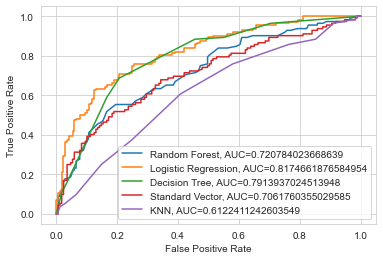

In [45]:
#### Random Forest Classifier Model ####
model = RandomForestClassifier(n_estimators = 230, random_state=42) # initialize random forest with 200 estimators due to size of data
model.fit(X_train, y_train)
print(f'Random Forest Classifier accuracy score: {model.score(X_test, y_test):.3f}')
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

### Logisitic Regression Model ###
logreg = LogisticRegression(solver = 'liblinear', penalty = 'l1', random_state = 42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Logistic Regression accuracy score: {logreg.score(X_test, y_test):.3f}')
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

### Decision Tree Classifier Model ###
parameters = {
                'criterion': ['gini', 'entropy'],
                'min_samples_leaf': [1, 10, 20],
                'max_depth': [3, 6, 9, 12],
                'class_weight': [None, 'balanced'],
                'max_features': [None, 'sqrt', 'log2'],
                'random_state': [42]
             }

clf = DecisionTreeClassifier()
grid_obj = GridSearchCV(clf, parameters, cv=5, scoring='accuracy') # Used GridSearch to hyper select parameters for Decision Tree
grid_obj.fit(X_train, y_train)
print(f'The best parameters used for Decision Tree Classifier: {grid_obj.best_params_}')
print(f'Decision Tree Classifier accuracy score: {grid_obj.score(X_test, y_test):.3f}')
y_pred_proba = grid_obj.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

### Support Vector Classifier Model ###
support_model = SVC(kernel='rbf', probability = True)
support_model.fit(X_train,y_train)
print(f'Support Vector Classifier accuracy score: {support_model.score(X_test, y_test):.3f}')
y_pred_proba = support_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Standard Vector, AUC="+str(auc))

### K-Nearest Neighbors Model ###
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100,250,500,750],
    "weights" : ["uniform" , "distance"],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'] 
    }
knn= GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=4) # Used GridSearch to hyper select parameters for KNN
knn.fit(X_train, y_train)
print(f'The best parameters used for K-Nearest Neigbors: {knn.best_params_}')
print(f'K-Nearest Neighbors accuracy score: {knn.score(X_test, y_test):.3f}')
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Feature Selection ###
Below I will use Select K best with the F-classif score function to select the 60 best features. 
- Used ANOVA F-score to select best features
- Train models again using less features

In [46]:
sel = SelectKBest(f_classif, k = 60) # use of f-classif to select feature by f-score ANOVA test
new = sel.fit_transform(dftrain.drop(['overall_survival'], axis = 1), dftrain.overall_survival)

cols = sel.get_support(indices= True)
features_new_df = dftrain.iloc[:,cols]

In [47]:
features_new_df.columns # to view which features were selected using SelectKBest

Index(['age_at_diagnosis', 'cohort', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index',
       'overall_survival_months', 'radio_therapy', 'tumor_size', 'msh6',
       'rad50', 'cdk6', 'cdkn2b', 'src', 'jak1', 'stat1', 'stat3', 'tp53bp1',
       'lfng', 'numbl', 'acvrl1', 'casp7', 'fas', 'folr1', 'gdf2', 'hras',
       'kdr', 'map2k1', 'mapk12', 'mmp14', 'pdgfa', 'pdgfb', 'rassf1',
       'rictor', 'rps6kb1', 'rps6kb2', 'smad3', 'tgfbr1', 'tsc1', 'gata3',
       'tbx3', 'map2', 'tubb4a', 'adgra2', 'asxl2', 'fanca', 'l1cam', 'myo3a',
       'nr2f1', 'setdb1', 'siah1', 'stmn2', 'akr1c2', 'cdk8', 'hsd17b10',
       'prkd1', 'sox9', 'star', 'pr_group',
       'cancer_type_detailed_Metaplastic Breast Cancer',
       'neoplasm_histologic_grade_3.0'],
      dtype='object')

In [48]:
X_new = features_new_df
y_new = dftrain['overall_survival']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.20, random_state = 42)

### Retraining the models after Feature Selection ###

Random Forest Clasifier accuracy score: 0.790
Logistic Regression accuracy score: 0.776
The best parameters used for Decision Tree classifier:{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'random_state': 42}
Decision Tree Classifier accuracy score: 0.762
Support Vector Classifier accuracy score: 0.730
The best parameters used for K-Nearest Neighbors: {'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'uniform'}
K-Nearest Neighbors accuracy score: 0.769


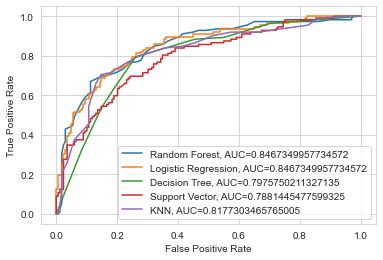

In [49]:
### Random Forest Classifier Model ###
model = RandomForestClassifier(n_estimators = 90, random_state=42) # initialize random forest with reduced estimators due to shrinking of data
model.fit(X_train_new, y_train_new)
print(f'Random Forest Clasifier accuracy score: {model.score(X_test_new, y_test_new):.3f}')
y_pred_proba_new = model.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_new,  y_pred_proba_new)
auc = metrics.roc_auc_score(y_test_new, y_pred_proba_new)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))


### Logistic Regression Model ###
logreg = LogisticRegression(solver='liblinear', penalty = 'l1', random_state = 42)
logreg.fit(X_train_new, y_train_new)
y_pred = logreg.predict(X_test_new)
print(f'Logistic Regression accuracy score: {logreg.score(X_test_new, y_test_new):.3f}')
y_pred_proba_new = logreg.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_new,  y_pred_proba_new)
auc = metrics.roc_auc_score(y_test_new, y_pred_proba_new)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

### Decision Tree Classifier Model ###
parameters = {
                'criterion': ['gini', 'entropy'],
                'min_samples_leaf': [1, 10, 20],
                'max_depth': [3, 6, 9, 12],
                'class_weight': [None, 'balanced'],
                'max_features': [None, 'sqrt', 'log2'],
                'random_state': [42]
             }

clf = DecisionTreeClassifier()
grid_obj = GridSearchCV(clf, parameters, cv=5, scoring='accuracy') # Using GridSearch to hyper select parameters for decision tree
grid_obj.fit(X_train_new, y_train_new)
y_pred = grid_obj.predict(X_test_new)
print(f'The best parameters used for Decision Tree classifier:{grid_obj.best_params_}')
print(f'Decision Tree Classifier accuracy score: {grid_obj.score(X_test_new, y_test_new):.3f}')
y_pred_proba_new = grid_obj.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_new,  y_pred_proba_new)
auc = metrics.roc_auc_score(y_test_new, y_pred_proba_new)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))


### Support Vector Classifier Model ###
support_model = SVC(probability= True, random_state=42)
support_model.fit(X_train_new,y_train_new)
print(f'Support Vector Classifier accuracy score: {support_model.score(X_test_new, y_test_new):.3f}')
y_pred_proba_new = support_model.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_new,  y_pred_proba_new)
auc = metrics.roc_auc_score(y_test_new, y_pred_proba_new)
plt.plot(fpr,tpr,label="Support Vector, AUC="+str(auc))

### K-Nearest Neighbors Classifier Model ###
params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'] 
    }
knn= GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, cv=5) # Using GridSearch to select hyperparameters for KNN
knn.fit(X_train_new, y_train_new)
print(f'The best parameters used for K-Nearest Neighbors: {knn.best_params_}')
print(f'K-Nearest Neighbors accuracy score: {knn.score(X_test_new, y_test_new):.3f}')
y_pred_proba_new = knn.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_new,  y_pred_proba_new)
auc = metrics.roc_auc_score(y_test_new, y_pred_proba_new)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## Comparison ##
### Before Feature Selection ###
__Random Forest Classifier accuracy score:__ 69%  <br>
__Logistic Regression accuracy score:__ 75% <br>
__Decision Tree Classifier accuracy score:__ 75% <br>
__Support Vector Classifier accuracy score:__ 62% <br>
__K-Nearest Neighbors accuracy score:__ 45.6% <br>
### After Feature Selection ###
__Random Forest Classifier accuracy score:__ 79% <br>
__Logistic Regression accuracy score:__ 77.6% <br>
__Decision Tree accuracy score:__ 76.2% <br>
__Support Vector Classifier accuracy score:__ 73% <br>
__K-Nearest Neighbors accuracy score:__ 77% <br>

### Result ###
All of the models improved drastically after the feature selection process. The greatest increase was in the KNN model, which increased in accuracy from 45% to 76%. The best performing model overall was the Random Forest model that had an accuracy of 79% after feature selection.
Models got more accurate because:
- F-classif method uses ANOVA f-values to select the best features for model accuracy
- Great reduction in features resulted in less noise for the models and as a result, better accuracy across all of the models

## Tuning XGB

In [50]:
# Using HP to find the best parameter values across various parameters

space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.randint('reg_lambda', 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.randint('min_child_weight', 10),
        'n_estimators': hp.uniform('n_estimators', 0,200),
        'random_state' : 42
        }

In [51]:
def objective(space):
    clf=XGBClassifier(
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), n_estimators = int(space['n_estimators']))
    
    evaluation = [( X_train_new, y_train_new), ( X_test_new, y_test_new)]
    
    clf.fit(X_train_new, y_train_new,
            eval_set=evaluation, eval_metric="auc",verbose=False)
    

    pred = clf.predict(X_test_new)
    accuracy = accuracy_score(y_test_new, pred>0.5)
    print ("SCORE:", accuracy)
    print(f'XBG score: {clf.score(X_test_new, y_test_new):.3f}')
    return {'loss': -accuracy, 'status': STATUS_OK }

In [52]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.6014234875444839                                     
XBG score: 0.601                                       
SCORE:                                                                            
0.6014234875444839                                                                
XBG score: 0.601                                                                  
SCORE:                                                                            
0.6014234875444839                                                                
XBG score: 0.601                                                                  
SCORE:                                                                            
0.6014234875444839                                                                
XBG score: 0.601                                                                  
SCORE:                                                                            
0.

In [53]:
print("The best hyperparameters are: ","\n")
print(best_hyperparams)

The best hyperparameters are:  

{'colsample_bytree': 0.6781527052094661, 'gamma': 1.7783899514929216, 'max_depth': 12.0, 'min_child_weight': 3, 'n_estimators': 183.10495179450254, 'reg_alpha': 40.0, 'reg_lambda': 0}


XBG score: 0.776
XGB params: <bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5982150245339849, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=1.0305603807808934, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=0,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=45, reg_lambda=0, ...)>


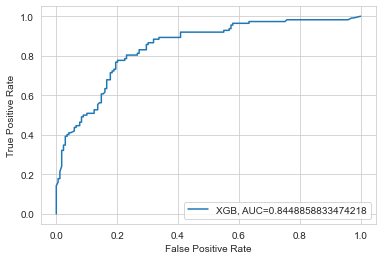

In [54]:
xgb_final = XGBClassifier(colsample_bytree = 0.5982150245339849, 
                          gamma=  1.0305603807808934, max_depth=  7,
                          min_child_weight=  0, n_estimators=  200, 
                          reg_alpha= 45, reg_lambda=  0)

xgb_final.fit(X_train_new, y_train_new)
print(f'XBG score: {xgb_final.score(X_test_new, y_test_new):.3f}')
print(f'XGB params: {xgb_final.get_params}')
y_pred_proba_new = xgb_final.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_new,  y_pred_proba_new)
auc = metrics.roc_auc_score(y_test_new, y_pred_proba_new)
plt.plot(fpr,tpr,label="XGB, AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()
